# <center>UrbanSound8K</center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-Import" data-toc-modified-id="Libraries-Import-1">Libraries Import</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2">Parameters</a></span></li><li><span><a href="#Import-of-the-Metadata-File" data-toc-modified-id="Import-of-the-Metadata-File-3">Import of the Metadata File</a></span></li><li><span><a href="#Creation-of-the-Dataset-Class" data-toc-modified-id="Creation-of-the-Dataset-Class-4">Creation of the Dataset Class</a></span></li><li><span><a href="#Instantiation-of-the-Dataset" data-toc-modified-id="Instantiation-of-the-Dataset-5">Instantiation of the Dataset</a></span></li><li><span><a href="#Dataset-Exploration" data-toc-modified-id="Dataset-Exploration-6">Dataset Exploration</a></span><ul class="toc-item"><li><span><a href="#Classes-Counts" data-toc-modified-id="Classes-Counts-6.1">Classes Counts</a></span></li><li><span><a href="#Duration-of-Events" data-toc-modified-id="Duration-of-Events-6.2">Duration of Events</a></span></li><li><span><a href="#Salience" data-toc-modified-id="Salience-6.3">Salience</a></span><ul class="toc-item"><li><span><a href="#Global" data-toc-modified-id="Global-6.3.1">Global</a></span></li><li><span><a href="#Per-Class" data-toc-modified-id="Per-Class-6.3.2">Per Class</a></span></li></ul></li><li><span><a href="#Folds-Distribution" data-toc-modified-id="Folds-Distribution-6.4">Folds Distribution</a></span></li><li><span><a href="#Visualition-of-an-Event" data-toc-modified-id="Visualition-of-an-Event-6.5">Visualition of an Event</a></span></li></ul></li><li><span><a href="#Creation-of-the-Model" data-toc-modified-id="Creation-of-the-Model-7">Creation of the Model</a></span></li><li><span><a href="#Creation-of-the-Pipeline" data-toc-modified-id="Creation-of-the-Pipeline-8">Creation of the Pipeline</a></span></li><li><span><a href="#Model-Training-and-Validation" data-toc-modified-id="Model-Training-and-Validation-9">Model Training and Validation</a></span></li></ul></div>

## Libraries Import

In [115]:
import os
import math
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torchmetrics import Accuracy, ConfusionMatrix
import torchaudio
import torchaudio.transforms as transforms
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Parameters

In [116]:
########################################################################
dataset_path = "dataset"
########################################################################
# Choose the device to operate on
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Used device: {device}")
########################################################################
# Transforms parameters
target_sample_rate = 22050
target_event_length = 4
n_samples = target_event_length * target_sample_rate
n_fft = 1024
hop_length = 512
f_max = 8000
n_mels = 64
n_frames = (target_sample_rate * target_event_length) // hop_length + 1
transforms_params = {
    "target_sample_rate": target_sample_rate,
    "target_event_length": target_event_length,
    "n_samples": n_samples,
    "n_fft": n_fft,
    "hop_length": hop_length,
    "f_max": f_max,
    "n_mels": n_mels,
    "n_frames": n_frames,
}

Used device: cpu


## Import of the Metadata File

In [117]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Creation of the Dataset Class

In [151]:
class UrbanSound8K(Dataset):
    
    def __init__(self, metadata, dataset_path, transforms_params, device):
        self.device = device
        self.metadata = metadata
        self.dataset_path = dataset_path
        self.n_folds = max(metadata["fold"])
        self.n_classes = len(metadata["class"].unique())
        self.classes_map = classes_map = pd.Series(metadata["class"].values,index=metadata["classID"]).sort_index().to_dict()
        self.target_sample_rate = transforms_params["target_sample_rate"]
        self.target_event_length = transforms_params["target_event_length"]
        self.n_samples = transforms_params["n_samples"]
        self.n_fft = transforms_params["n_fft"]
        self.hop_length = transforms_params["hop_length"]
        self.f_max = transforms_params["f_max"]
        self.n_mels = transforms_params["n_mels"]
        self.n_frames = transforms_params["n_frames"]
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        label = torch.tensor(self._get_event_class(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self._spectrogram_transform(signal)
        signal = self._db_transform(signal)
        return signal, label
    
    def _get_event_class(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        # If signal has multiple channels, mix down to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resample_transform = resample_transform.to(self.device)
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.n_samples:
            signal = signal[:, :self.n_samples]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.n_samples:
            num_missing_samples = self.n_samples - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _spectrogram_transform(self, signal):
        mel_spectrogram_transform = transforms.MelSpectrogram(
                                                        sample_rate = self.target_sample_rate,
                                                        n_fft = self.n_fft,
                                                        hop_length = self.hop_length,
                                                        f_max = self.f_max,
                                                        n_mels = self.n_mels,
                                                        power = 2,
                                                        normalized=True
                                                        )      
        mel_spectrogram_transform = mel_spectrogram_transform.to(self.device)
        signal = mel_spectrogram_transform(signal)
        return signal
    
    def _db_transform(self, signal):
        db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
        db_transform = db_transform.to(self.device)
        signal = db_transform(signal)
        return signal
        

## Instantiation of the Dataset

In [152]:
# Instantiate a dataset object
dataset = UrbanSound8K(
    metadata=metadata,
    dataset_path=dataset_path, 
    transforms_params=transforms_params,
    device=device
)

## Dataset Exploration

### Classes Counts

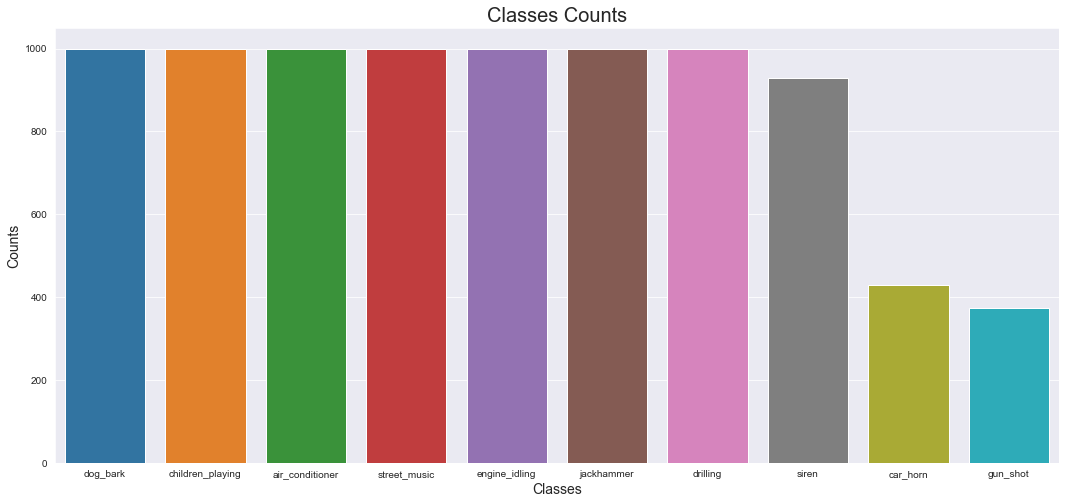

In [153]:
class_vc = dataset.metadata["class"].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(x=class_vc.index, y=class_vc.values)
plt.title("Classes Counts", fontsize=20)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Duration of Events

Text(0, 0.5, 'Counts')

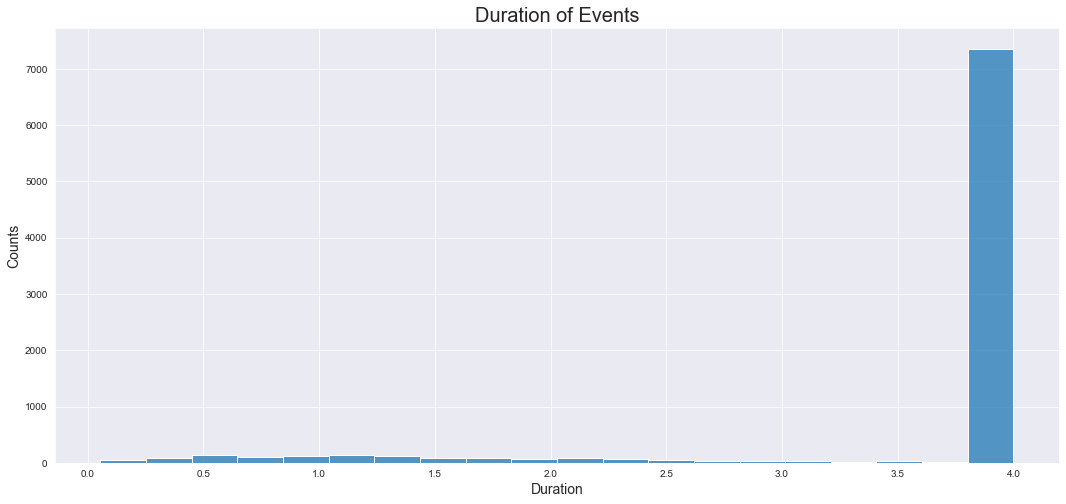

In [154]:
duration = dataset.metadata["end"] - dataset.metadata["start"]
plt.figure(figsize=(18,8))
sns.histplot(data=duration, x=duration.values, bins=20)
plt.title("Duration of Events", fontsize=20)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Counts", fontsize=14)

### Salience

#### Global

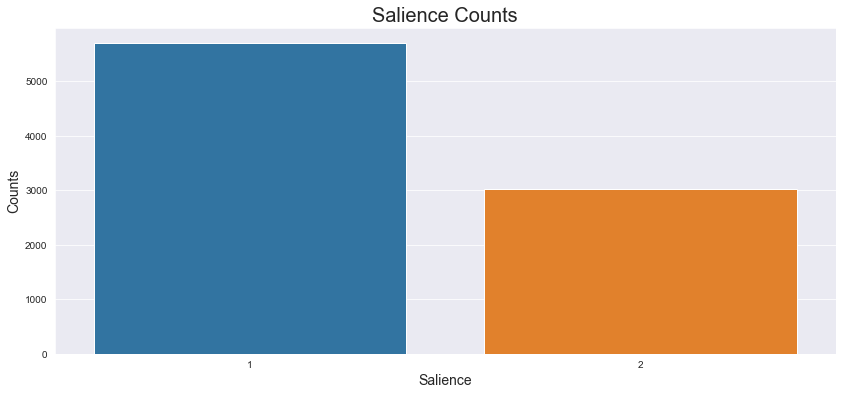

In [155]:
salience_vc = dataset.metadata["salience"].value_counts()
plt.figure(figsize=(14,6))
sns.barplot(x=salience_vc.index, y=salience_vc.values)
plt.title("Salience Counts", fontsize=20)
plt.xlabel("Salience", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

#### Per Class

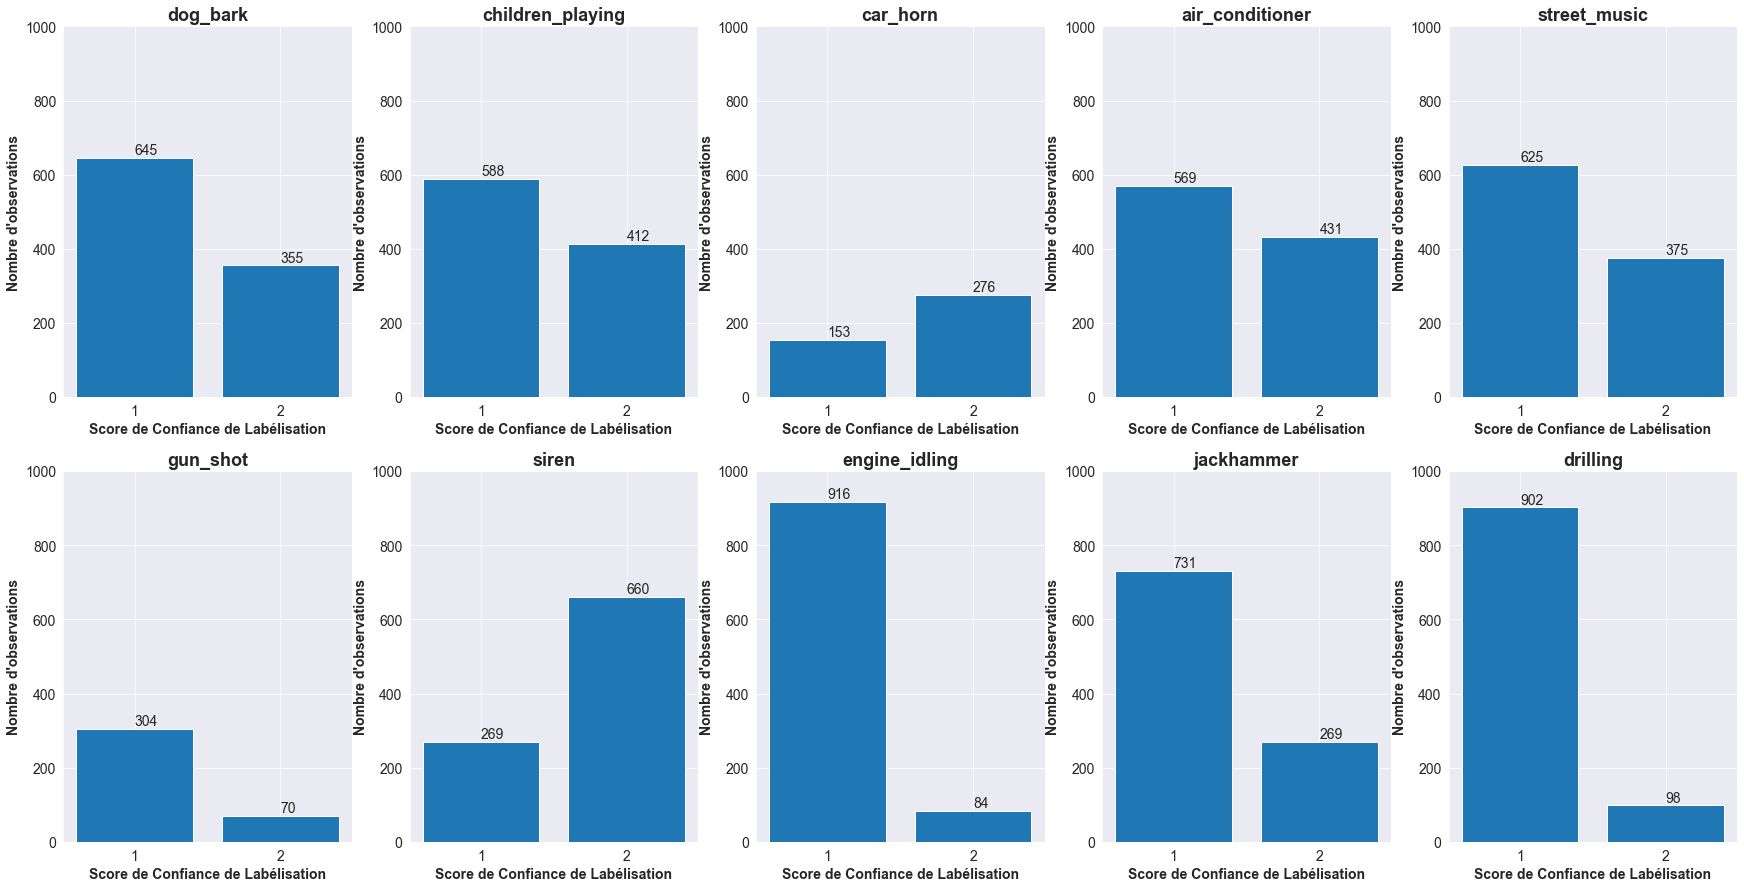

In [156]:
# Set subplot figure parameters
n_cols = 5
n_rows = math.ceil(len(metadata["class"].unique())/n_cols) # Compute the number of rows based on the number of labels and columns
p_count = 1

fig = plt.figure(figsize=(30,15))

# For each unique class
for unique_class in metadata["class"].unique():
    # Filter the metadata based on the label
    filtered_metadata = metadata[metadata["class"]==unique_class]
    # Initialize a dictionnary to count the number events for each salience score
    salience_dict = {1:0, 2:0}
    # For each row of the filtered metadata
    for index, row in filtered_metadata.iterrows():
        # Get the salience score
        salience_score = row[4]
        # Populate the dictionnary
        if salience_score not in salience_dict:
            salience_dict[salience_score] = 1
        else:
            salience_dict[salience_score] += 1
    plt.subplot(n_rows, n_cols, p_count) 
    # Plot a bar graph with all salience scores on the x axis
    plt.bar(range(len(salience_dict)), list(salience_dict.values()), align='center')
    plt.ylim([0, 1000])
    # Write the counts on each bar
    for salience in salience_dict.keys():
        plt.text(salience-1, (filtered_metadata['salience'] == salience).sum()+10, str((filtered_metadata['salience'] == salience).sum()), fontsize=14)
    # Write the ticks on the x axis
    plt.xticks(range(len(salience_dict)), list(salience_dict.keys()), fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"{unique_class}", fontweight="bold", fontsize=18)
    plt.xlabel("Score de Confiance de Labélisation", fontweight="bold", fontsize=14)
    plt.ylabel("Nombre d'observations", fontweight="bold", fontsize=14)
    p_count += 1

plt.show()

### Folds Distribution

In [157]:
# Group by fold and label and pivot
folds_vc = metadata.groupby(["fold", "class"], dropna=False, as_index=False)["class"].size()
folds_vc.pivot(index="class", columns="fold", values="size")

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100
car_horn,36,42,43,59,98,28,28,30,32,33
children_playing,100,100,100,100,100,100,100,100,100,100
dog_bark,100,100,100,100,100,100,100,100,100,100
drilling,100,100,100,100,100,100,100,100,100,100
engine_idling,96,100,107,107,107,107,106,88,89,93
gun_shot,35,35,36,38,40,46,51,30,31,32
jackhammer,120,120,120,120,120,68,76,78,82,96
siren,86,91,119,166,71,74,77,80,82,83


### Visualition of an Event

,slice_file_name,fsID,start,end,salience,fold,classID,class
5102,197318-6-3-0.wav,197318,6.801996,8.759765,1,1,6,gun_shot


tensor([[ -66.0135,  -58.0419,  -59.2200,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -80.8657,  -78.8181,  -84.9977,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -87.5378,  -82.6053,  -86.2009,  ..., -100.0000, -100.0000,
         -100.0000],
        ...,
        [ -87.0804,  -87.0567,  -88.0540,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -88.9847,  -88.3569,  -88.2416,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -91.4084,  -88.9781,  -88.6425,  ..., -100.0000, -100.0000,
         -100.0000]])
tensor(12.8006)
tensor(-100.)


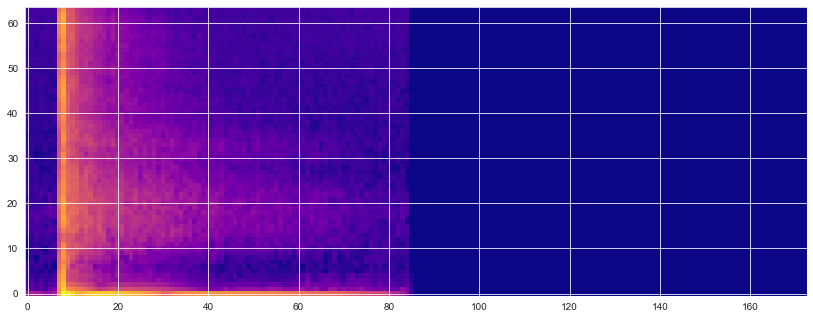

In [158]:
# Input annotations filtering critera
label = "gun_shot"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = dataset.metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select the desired number of events from the filtered annotations
selected_event = filtered_metadata.sample(n=1) 
display(selected_event)
selected_event_index = selected_event.index.item()

spectrogram, label = dataset[selected_event_index]

spectrogram = spectrogram.cpu()
spectrogram = torch.squeeze(spectrogram)

print(spectrogram)
print(spectrogram.max())
print(spectrogram.min())

plt.figure(figsize=(14,14))
plt.imshow(spectrogram, origin="lower", cmap='plasma')

# Build the audio path
selected_event_fold = f"fold{selected_event.iloc[0]['fold']}"
selected_event_filename = selected_event.iloc[0]["slice_file_name"]
selected_audio_path = os.path.join(dataset_path, selected_event_fold, selected_event_filename)
display(IPython.display.Audio(filename=selected_audio_path))

## Creation of the Model

In [159]:
class Model(nn.Module):
    
    def __init__(self, out_dim):
        
        super().__init__()
        # Definition of the model
        self.conv1 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=1,
                                            out_channels=16,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv2 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=16,
                                            out_channels=32,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv3 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=32,
                                            out_channels=64,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )
        self.conv4 = nn.Sequential(
                                nn.Conv2d(
                                            in_channels=64,
                                            out_channels=128,
                                            kernel_size=3,
                                            stride=1,
                                            padding=2
                                            ),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2)
                                )  
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 12, out_dim)
    
    def forward(self, input_data):
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        
        return logits

## Creation of the Pipeline

In [160]:
class Pipeline(pl.LightningModule):
    def __init__(self, model, classes_map, lr):
        super().__init__()
        
        # Save hyperparameters to the checkpoint
        self.save_hyperparameters()        

        # Instantiate the model
        self.model = model
           
        # Instiation of the metrics
        self.accuracy = Accuracy(num_classes=len(classes_map))
        self.confmat = ConfusionMatrix(num_classes=len(classes_map))        
        
        # Instantiation of the classes map
        self.classes_map = classes_map
        
        # Instantiation of the number of classes
        self.n_classes = len(classes_map)
        
        # Instatiation of the learning rate
        self.lr = lr
        
        
    def configure_optimizers(self):
        
        optimizer = Adam(self.model.parameters(), lr=self.lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "validation_loss",
                        "frequency": 1
                        }
                }
        
    def training_step(self, train_batch, batch_idx):
        
        # Unpack the training batch
        inputs, targets = train_batch
        # Pass the inputs to the model to get the logits
        logits = self.model(inputs)
        # Compute the loss
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy
        accuracy = self.accuracy(logits, targets)
        # Log the loss
        self.log("train_loss", loss, on_step=True, on_epoch=True)

        return {"inputs":inputs, "targets":targets, "preds":preds, "loss":loss, "accuracy":accuracy}
    
    
    def training_epoch_end(self, outputs):
        
        if self.current_epoch == 0:
            input_height = outputs[0]["inputs"].size()[2]
            input_width = outputs[0]["inputs"].size()[3]
            input_sample = torch.rand((1,1,input_height,input_width))
            self.logger.experiment.add_graph(self.model(input_sample))

            
    def validation_step(self, validation_batch, batch_idx):
        
        # Unpack the validation batch
        inputs, targets = validation_batch
        # Pass the inputs to the model to get the logits
        logits = self.model(inputs)
        # Compute the loss and log it for early stopping monitoring
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy for this batch
        accuracy = self.accuracy(preds, targets)
        # Log the loss and the accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "preds":preds, "loss":loss, "accuracy":accuracy}
    
    
    def validation_epoch_end(self, outputs):
        
        # Concatenate the predictions of all batches
        preds = torch.cat([output["preds"] for output in outputs]).cpu()
        # Concatenate the targets of all batches
        targets = torch.cat([output["targets"] for output in outputs]).cpu()
        # Compute the confusion matrix, turn it into a DataFrame, generate the plot and log it
        confmat = ConfusionMatrix(num_classes=self.n_classes)
        cm = confmat(preds, targets)
        df_cm = pd.DataFrame(cm.numpy(), index = range(self.n_classes), columns=range(self.n_classes))
        plt.figure()
        ticklabels = list(self.classes_map.values())
        fig = sns.heatmap(df_cm, xticklabels=ticklabels , yticklabels=ticklabels , annot=True, cmap='Spectral').get_figure()
        self.logger.experiment.add_figure("Confusion matrix", fig, self.current_epoch)
        # Compute the average loss
        avg_loss = torch.mean(torch.stack([output["loss"] for output in outputs]))
        print(f"Average loss over validation epoch: {avg_loss}")

## Model Training and Validation

In [ ]:
# Batch size
batch_size = 10
# Number of epochs
n_epochs = 30
# Learning rate
learning_rate = 0.001

num_classes = len(dataset.metadata["class"].unique())

for i in range(1,dataset.n_folds+1):
    
    print(f"========== Cross-validation {i} on {dataset.n_folds} ==========")
    
    # Get the train and validation sets
    train_metadata = dataset.metadata.drop(dataset.metadata[dataset.metadata["fold"]==i].index)
    validation_metadata = dataset.metadata[dataset.metadata["fold"]==i]
    train_indices = train_metadata.index
    validation_indices = validation_metadata.index 
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    # Create the train and validation dataloaders
    train_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size, 
                            sampler=train_sampler,
                            )
    
    validation_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size,
                            sampler=validation_sampler,
                            )

    # Instantiate the model
    model = Model(out_dim=dataset.n_classes)
    
    # Instantiate the pipeline
    pipeline = Pipeline(model, classes_map=dataset.classes_map, lr=2e-4)
    
    # Instantiate the logger
    run_name = f"{dataset.n_folds} folds cross-validation - Validation on fold {i}"
    tensorboard_logger = TensorBoardLogger(save_dir="tb_logs", name=run_name)
    
    # Instantiate a learning rate monitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    # Instantiate early stopping based on epoch validation loss
    early_stopping = EarlyStopping("validation_loss", patience=6, verbose=True)
    
    # Instantiate the trainer and train the model
    trainer = Trainer(
                    max_epochs=n_epochs, 
                    logger=tensorboard_logger,
                    log_every_n_steps = 1,
                    callbacks=[early_stopping, lr_monitor]
                    )   
    
    trainer.fit(pipeline, train_dataloader, validation_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


========== Cross-validation 1 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:655: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Average loss over validation epoch: 2.579399585723877


/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


========== Cross-validation 2 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Model           | 173 K 
1 | accuracy | Accuracy        | 0     
2 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Average loss over validation epoch: 2.756598949432373


Training: 0it [00:00, ?it/s]